# Classer avec la méthode des k-Plus Proches Voisins

Dans ce TP nous allons implémenter notre première Intelligence Artificielle à partir de la méthode des k-Plus Proches Voisins étudiée en TD. Nous allons implémenter, tester, évaluer et étudier cette méthode de classification sur un jeu de données réelles.

## A. Charger, explorer puis préparer le tableau de données

Commencez par importer dans un Dataframe `zoo` les données du fichier `zoo.csv`.

In [31]:
import pandas as pd
zoo = pd.read_csv("./donnees/zoo.csv")

Explorez le dataset `zoo`: Combien d'individus? Combien de descripteurs? Quelle est la nature (type) des descripteurs? Y-a-t'il des valeurs manquantes?

In [32]:
print(zoo.shape)

(100, 18)


Dans ce dataset, la dernière colonne `type` correspond à la catégorie de l'animal :
|  Type  |    Catégorie    |
| :---------:|---------|
| 1 |Mammifères|
| 2 |Oiseaux|
| 3 |Reptiles|
| 4 |Poissons|
| 5 |Amphibiens|
| 6 |Insectes|
| 7 |Invertébrés|

Notre IA devra prédire la catégorie d'un animal à partir de sa description (sans le `Name`). Il s'agit donc d'une tâche de prédiction à **7 classes**.

Observez la distribution des individus selon la variable de classe (`type`) et constatez le déséquilibre des classes. Cela aura-t'il une incidence sur la méthode de k-PPV?

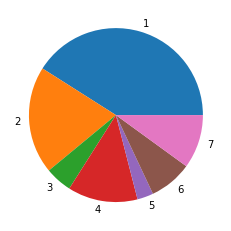

In [24]:
import matplotlib.pyplot as plt
import numpy as np
labels, sizes = np.unique(zoo['type'], return_counts=True)
plt.pie(sizes, labels=labels)
plt.show()

A partir du dataframe `zoo`, vous allez construire deux tableaux Numpy :
- `X` est la matrice (100x16) des descriptions des individus
- `y` est le vecteur contenant les (100) catégories d'animaux 

In [25]:
#x = zoo[["hear", "feathers", "eggs", "milk", "airbone", "aquatic", "predator", "toothed", "backbone", "breathes", "venomous", "fins", "legs", "tail", "domestic", "size"]]
#y = zoo['type']
#print(x.shape)
#print(y.shape)

x = np.array(zoo.iloc[:, 1 : -1])
y = np.array(zoo.iloc[:, -1])
print(x.shape)
print(y.shape)

(100, 16)
(100,)


Nous allons à présent découper `X` et `y` en deux sous-ensembles :
- `X_train` : qui contient des individus que la méthode k-PPV utilisera pour prédire
- `X_test`  : qui contient des individus que nous utiliserons pour évaluer notre IA (et ainsi ajuster le paramètre k)
- `y_train` : qui contient les labels des individus de `X_train`
- `y_test`  : qui contient les labels des individus de `X_test`

Ecrire une fonction (générique) `train_test_split(X, y, train_ratio)` qui réalise un tel découpage :

In [26]:
def train_test_split(X, y, train_ratio):
    """découpe un dataset X en deux ensembles d'entraînement (train) et de test ainsi que les labels associés

    Args:
        X (matrice Numpy): le dataset à découper
        y (vecteur Numpy): le vecteur des labels à découper
        train_ratio (float): entre 0.0 et 1.0 = proportion du dataset à inclure dans l'ensemble d'entraînement (train)

    Returns:
        X_train (matrice Numpy): le sous-ensemble d'entraînement
        X_test (matrice Numpy):  le sous-ensemble de test
        y_train (vecteur Numpy): les labels données d'entraînement
        y_test (vecteur Numpy):  les labels données de test

    """
    n = X.shape[0]
    if y.shape[0] != n:
        return None
    ids = np.arange(n)
    np.random.shuffle(ids)
    nbre_train = int(n * train_ratio)
    ids_train, ids_test = ids[:nbre_train], ids[nbre_train:]
    return X[ids_train, :], X[ids_test, :], y[ids_train], y[ids_test]

Utilisez votre fonction pour découper notre dataset `X` en deux sous-ensembles de mêmes tailles.

Vérifiez que les déséquilibres des classes sont globalement respectés (relancez le découpage si certaines classes sont absentes dans l'un des deux sous-ensembles).

In [27]:
X_train, X_test, y_train, y_test = train_test_split(x, y, 0.7)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(70, 16)
(30, 16)
(70,)
(30,)


---

## B. Implémenter et évaluer la méthode k-PPV (non-pondérée)

Définissez une fonction `predict_kNN(k, X, y, x_new)` qui prédit la classe d'une description `x_new` par la méthodes k-PPV non-pondérée utilisée sur les données `X` de ayant pour labels `y` avec la distance Euclidienne.

In [37]:
def predict_kNN(k, X, y, x_new):
    """implémente le classifieur du k-Plus Proches Voisins 

    Args:
        k (int): nombre de voisins à utiliser pour prédire
        X (matrice Numpy): le dataset des données d'entraînement
        y (vecteur Numpy): le vecteur des labels des données d'entraînement
        x_new (vecteur Numpy) : le vecteur de description d'une nouvelle donnée à classer

    Returns:
        y_new (label):  le label prédit

    """
    distance = np.linalg.norm(X-x_new, axis=1)
    ids_proches_voisins = np.argsort(distance)[:k]
    class_proches_voisins = y[ids_proches_voisins]
    labels, counts = np.unique(class_proches_voisins, return_counts=True)
    return labels[counts.argsort()[-1]]

Utilisez la fonction `predict_kNN` pour prédire la classe de l'individu situé à l'indice 23 dans `X_test` à partir des données d'entraînement (`X_train`, `y_train`). Affichez la classe prédite selon différentes valeurs de `k` et comparez avec la vraie classe de l'individu (`y_test[23]`). 

Définissez une fonction `error_kNN(k, X_train, y_train, X_test, y_test)` qui renvoie le taux d'erreur de prédiction de la méthode k-PPV sur des données de test. 

In [38]:
def error_kNN(k, X_train, y_train, X_test, y_test):
    """calcule le taux d'erreur de prédiction par k-PPV sur les données de test 

    Args:
        k (int): nombre de voisins à utiliser pour prédire
        X_train (matrice Numpy): le dataset des données d'entraînement
        y_train (vecteur Numpy): le vecteur des labels des données d'entraînement
        X_test (vecteur Numpy) : le dataset des données de test
        y_test (vecteur Numpy): le vecteur des labels des données de test


    Returns:
        error_rate (float):  le taux d'erreur de prédiciton (Nb. mauvaises prédictions / Nb. prédictions)

    """
    prediction = [predict_kNN(k, X_train, y_train, X_test[i, :]) for i in range(y_test.size)]
    return 1 - sum(prediction == y_test) / y_test.size

Tracez la courbe du taux d'erreur en fonction du paramètre `k`. Quelle valeur choisirez-vous pour `k`? Est-ce que votre classifieur vous semble performant?

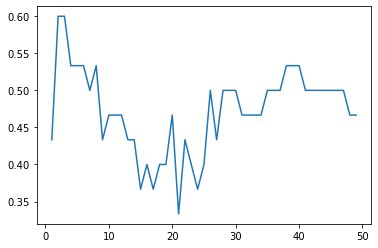

In [46]:
plt.plot(range(1, 50), [error_kNN(i, X_train, y_train, X_test, y_test) for i in range(1, 50)])
plt.show()

Avant de conclure (trop vite!)... quel serait le taux d'erreur d'un classifieur k-PPV qui fonderait ses prédictions sur la taille des animaux uniquement (descripteur `size`)?

## C. Normaliser les données

Vous avez constaté que tous les descriteurs n'ont pas la même influence dans le calcul des distances entre individus, du fait de l'amplitude des valeurs associée à chaque descripteurs.

Pour faire en sorte que chaque descripteur ait la même influence dans le traitement du tableau de données, on procède à une **normalisation** des données. 

> Normaliser un ensemble $Z$ consiste à ramener toutes ses valeurs dans l'intervalle $[0,1]$ par l'opération : $$\tilde{z}_{i}=\frac{z_{i}-min_Z}{max_Z-min_Z}$$
>

Complétez la classe `Normalizer` ci-dessous qui définit un **outil** de normalisation d'un jeu de données. La normalisation d'un jeu de données procédera en deux temps :
- calcul des paramètres de la fonction de normalisation sur des données (méthode `.fit()`)
- application de la fonction de normalisation sur des données (méthode `.transform()`)

In [ ]:
class Normalizer:
    
    min = None
    max = None
    
    def fit(self, X):
        """calcule les min et max de chaque colonne de X"""
        ...
    
    def transform(self, X):
        """renvoie X normalisé"""
        ...
        

Appliquez la normalisation sur l'ensemble des individus (100 descriptions) puis comparez l'erreur faite par la méthode des k-PPV avant et après normalisation. Concluez sur l'utilité de cette étape de normalisation.

## D. Implémenter et évaluer la méthode k-PPV pondérée

Implémentez la variante pondérée de la méthode k-PPV dans une version généralisée de la fonction `predict_kNN(k, X, y, x_new, weights)`

In [ ]:
def predict_kNN(k, X, y, x_new, weights='uniform'):
    """implémente le classifieur du k-Plus Proches Voisins 

    Args:
        k (int): nombre de voisins à utiliser pour prédire
        X (matrice Numpy): le dataset des données d'entraînement
        y (vecteur Numpy): le vecteur des labels des données d'entraînement
        x_new (vecteur Numpy) : le vecteur de description d'une nouvelle donnée à classer
        weights ('uniform', 'distance') : méthode de pondération utilisée pour la prédiction

    Returns:
        y_new (label):  le label prédit

    """
    ...

Généralisez également la fonction d'évaluation `error_kNN(k, X_train, y_train, X_test, y_test, weights)` avec l'argument supplémentaire `weights`

In [ ]:
def error_kNN(k, X_train, y_train, X_test, y_test, weights='uniform'):
    """calcule le taux d'erreur de prédiction par k-PPV sur les données de test 

    Args:
        k (int): nombre de voisins à utiliser pour prédire
        X_train (matrice Numpy): le dataset des données d'entraînement
        y_train (vecteur Numpy): le vecteur des labels des données d'entraînement
        X_test (vecteur Numpy) : le dataset des données de test
        y_test (vecteur Numpy): le vecteur des labels des données de test
        weights ('uniform', 'distance') : méthode de pondération utilisée dans k-PPV


    Returns:
        error_rate (float):  le taux d'erreur de prédiciton (Nb. mauvaises prédictions / Nb. prédictions)

    """
    ...

Enfin, comparez l'erreur faite par chacune des deux versions de la méthode k-PPV (pondérée ou non).